In [157]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from keras_vggface.vggface import VGGFace

from utils.DataLoader import load_data
from models.SiameseNet import SiameseModel, build_network
from models.Attention import CBAM

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display
import matplotlib.cm as cm

In [158]:
# !pip install matplotlib

In [159]:
def load_datasets():
    train_dataset = load_data('data\\KinFaceWIITrainFolds.tfrecords')#.take(10)
    validation_dataset = load_data('data\\KinFaceWIITestFolds.tfrecords')#.take(1)
    
    return train_dataset, validation_dataset
    

In [160]:
def create_model():
    vgg = VGGFace(model='vgg16', include_top=False, input_shape=(64, 64, 3))

    input_layer = layers.Input((64, 64, 3))
#     mask_input = mask_model.input
#     mask_output = mask_model.output
#     mask = mask_model(input_layer)
#     cbam = CBAM(3)(input_layer)
#     x = layers.Add()([cbam, input_layer])
    x = CBAM(3)(input_layer)
    x = vgg(x)
    x = layers.Flatten()(x)
    # x = layers.Dense(4096, activation='relu')(x)
    output_layer = layers.Dense(4096)(x)

    network = keras.Model(inputs=input_layer, outputs=output_layer)

    for layer in vgg.layers:
        layer.trainable  = False

#     network.summary()
#     vgg.summary()
    
#     def applay_mask(mask):
#         mask = tf.argmax(mask, -1) != 0
#         mask = tf.expand_dims(mask, 3)
#         mask = tf.cast(mask, tf.float32)
        
#         return mask

#     mask_model = keras.models.load_model('model.h5')
#     mask_model.trainable = False
#     siamese_network = build_network(network)
#     build_mask_layer = layers.Lambda(lambda x: .5 * applay_mask(mask_model(x)) + x * .5)
    
#     input_layer_for_mask = layers.Input((64, 64, 3))
#     x = build_mask_layer(input_layer_for_mask)
#     siamese = siamese_network(network)
    
#     final_model = keras.models.Model(inputs=input_layer_for_mask, outputs=output)
    
    siamese_network = build_network(network)
    model = SiameseModel(siamese_network)
    
    return model, network#, final_model

In [166]:
model, network = create_model()

In [167]:
train_dataset, validation_dataset = load_datasets()

In [168]:
mask_model = keras.models.load_model('model.h5')

@tf.function(jit_compile=True)
def prior_attention(x):
    anchor = x['anchor']
    neg = x['neg']
    pos = x['pos']

    anchor_mask = mask_model(anchor)
    anchor_mask = tf.argmax(anchor_mask, -1)
    anchor_mask = tf.expand_dims(anchor_mask, 3)
    anchor_mask = tf.cast(anchor_mask, tf.float32)
    
    pos_mask = mask_model(pos)
    pos_mask = tf.argmax(pos_mask, -1)
    pos_mask = tf.expand_dims(pos_mask, 3)
    pos_mask = tf.cast(pos_mask, tf.float32)
    
    neg_mask = mask_model(neg)
    neg_mask = tf.argmax(neg_mask, -1)
    neg_mask = tf.expand_dims(neg_mask, 3)
    neg_mask = tf.cast(neg_mask, tf.float32)

    anchor = anchor * .8 + anchor_mask * .2
    pos = pos * .8 + pos_mask * .2
    neg = neg * .2 + neg_mask * .2

    return {
        'anchor': anchor,
        'pos': pos,
        'neg': neg
    }

In [169]:
# train_dataset = train_dataset.map(prior_attention).prefetch(10)
# validation_dataset = validation_dataset.map(prior_attention).prefetch(10)

In [170]:
# model.build([[None, 64, 64, 3], [None, 64, 64, 3], [None, 64, 64, 3]])
model.compile(optimizer=keras.optimizers.Adam(0.0001))

# checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='tmp/checkpoints/', monitor='val_accuracy')
# earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy')

history = model.fit(train_dataset, epochs=3, validation_data=validation_dataset)

Epoch 1/3
    175/Unknown - 36s 190ms/step - loss: 3.3862 - accuracy: 0.9518 - ap_mean: 5.4211 - ap_std: 7.1592 - an_mean: 2.5349 - an_std: 7.1592

KeyboardInterrupt: 

In [8]:
input_layer = model.layers[0].layers[3].layers[0].input
output_layer = model.layers[0].layers[3].layers[1].output

In [9]:
attention_model = keras.Model(inputs=input_layer, outputs=output_layer)

In [207]:
imgs = validation_dataset.take(1)

for img in imgs:
    anchor = img['anchor']
    pos = img['pos']
    neg = img['neg']

In [208]:
# attention = attention_model(img)

In [181]:
def make_gradcam_heatmap(img_array, grad_model, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [178]:
vgg = network.layers[2].layers

input_layer = network.layers[0].input
x = network.layers[1](input_layer)

x = vgg[0](x)
x = vgg[1](x)
x = vgg[2](x)

x = vgg[3](x)
x = vgg[4](x)
x = vgg[5](x)

x = vgg[6](x)
x = vgg[7](x)
x = vgg[8](x)
x = vgg[9](x)

x = vgg[10](x)
x = vgg[11](x)
x = vgg[12](x)
x = vgg[13](x)

x = vgg[14](x)
x = vgg[15](x)
x = vgg[16](x)
last_conv_layer = vgg[17](x)

x = network.layers[3](last_conv_layer)
output_layer = network.layers[3](x)


flattened_model = keras.Model(inputs=input_layer, outputs=[last_conv_layer, output_layer])

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2


In [179]:
flattened_model.summary()

Model: "model_48"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            multiple             0                                            
__________________________________________________________________________________________________
cbam_1 (CBAM)                   (None, 64, 64, 3)    104         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            multiple             0           cbam_1[18][0]                    
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 64, 64, 64)   1792        input_1[5][0]                    
___________________________________________________________________________________________

In [230]:
def plot_single_image(image, flattened_model):
    heatmap = make_gradcam_heatmap(np.array([image]), flattened_model)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((image.shape[0], image.shape[1]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * .4 + image
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img


def plot_grad_cam(anchor, pos, neg, idx, flattened_model):
    anchor_grad_cam = plot_single_image(anchor[idx], flattened_model)
    pos_grad_cam = plot_single_image(pos[idx], flattened_model)
    neg_grad_cam = plot_single_image(neg[idx], flattened_model)
    
    return anchor_grad_cam, pos_grad_cam, neg_grad_cam

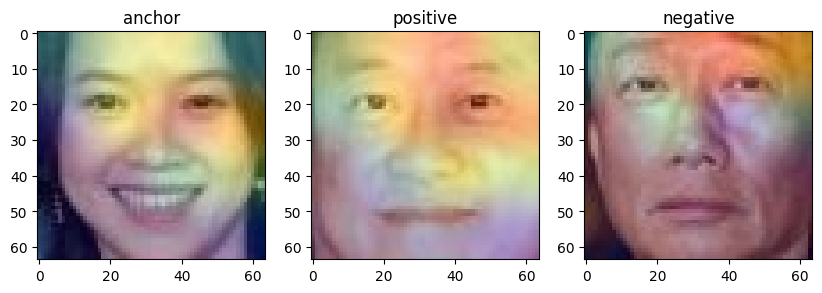

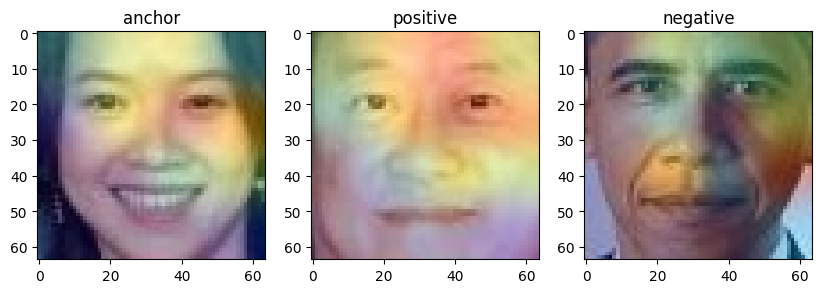

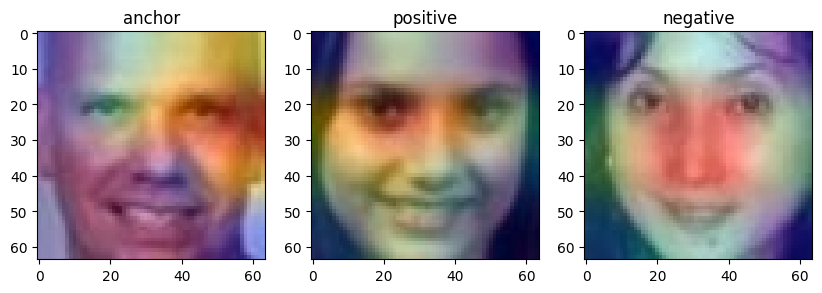

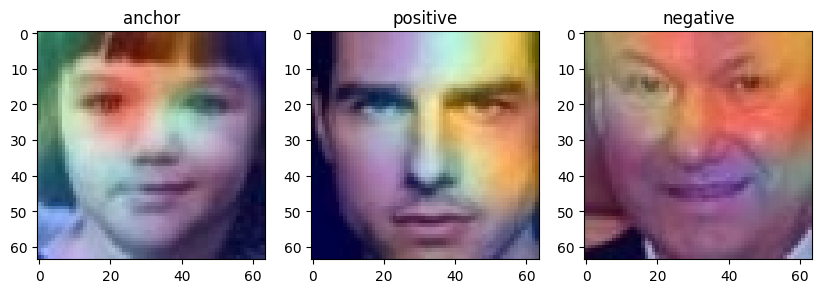

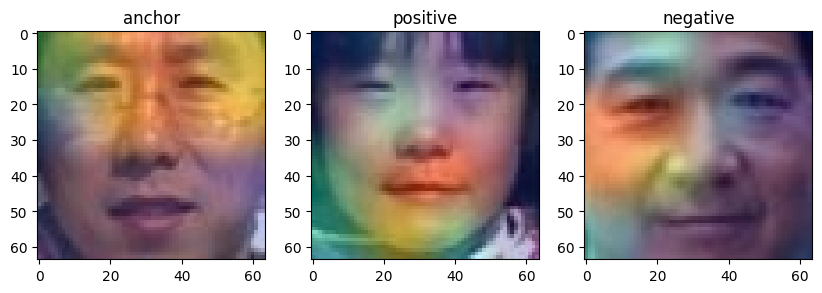

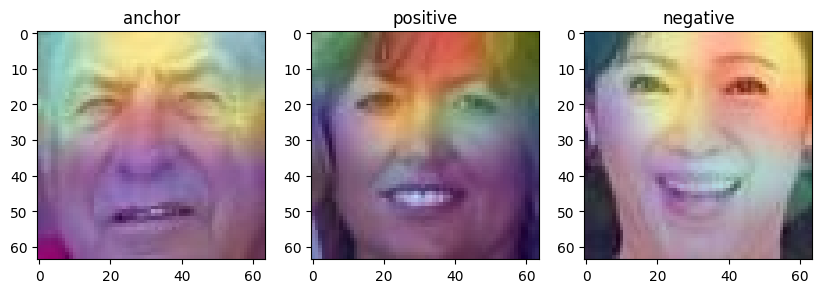

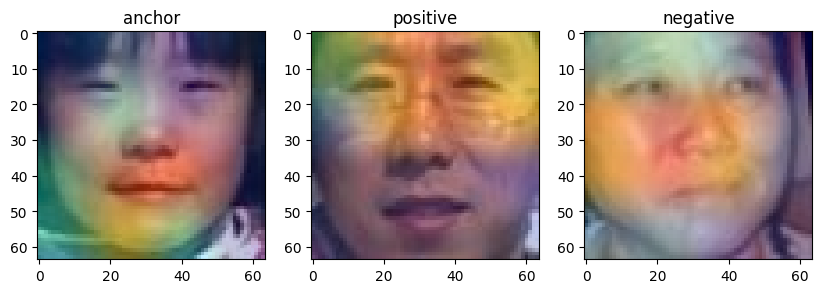

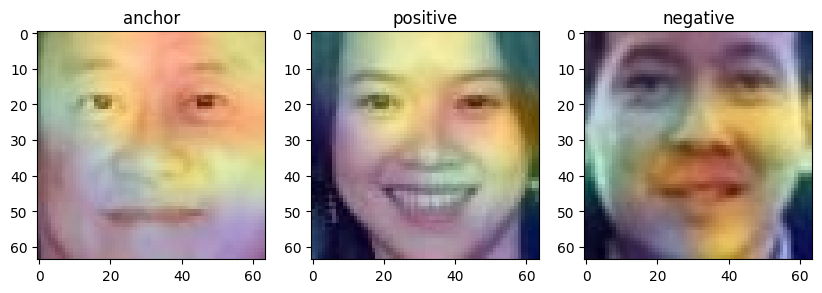

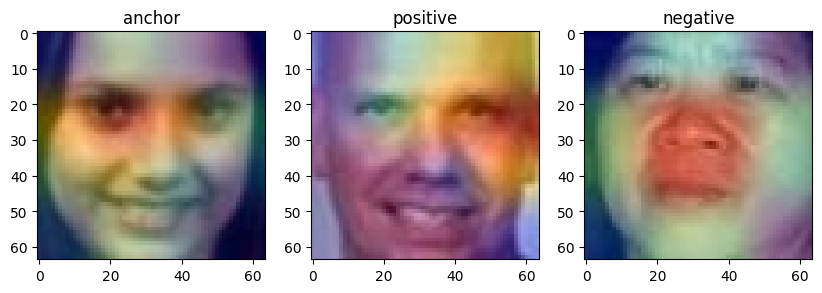

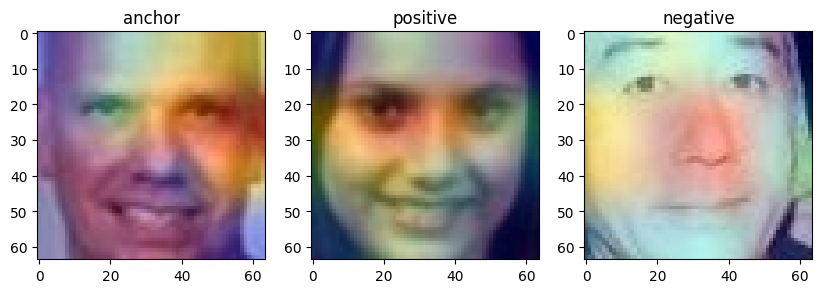

In [242]:
for i in range(10):
    idx = i
    a, p, n = plot_grad_cam(anchor, pos, neg, idx, flattened_model)

    fig, axs = plt.subplots(1, 3, figsize=(10, 10))

    axs[0].imshow(a)
    axs[0].title.set_text('anchor')

    axs[1].imshow(p)
    axs[1].title.set_text('positive')

    axs[2].imshow(n)
    axs[2].title.set_text('negative')

    plt.show()

In [ ]:
for layer in network.layers:
    print(layer.name)

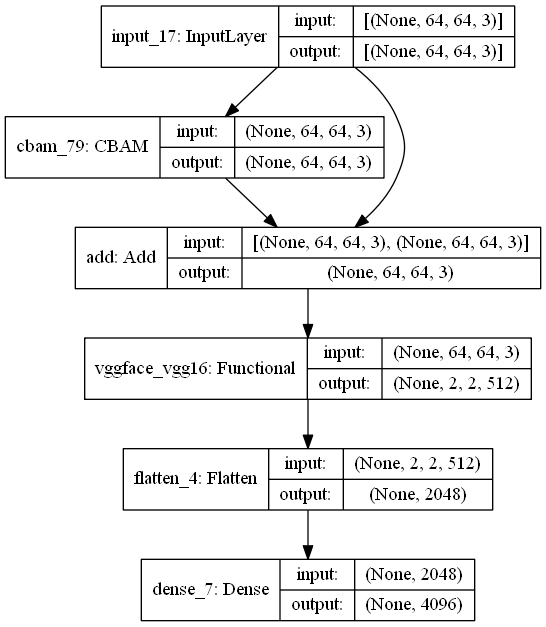

In [247]:
keras.utils.plot_model(network, show_shapes=True)

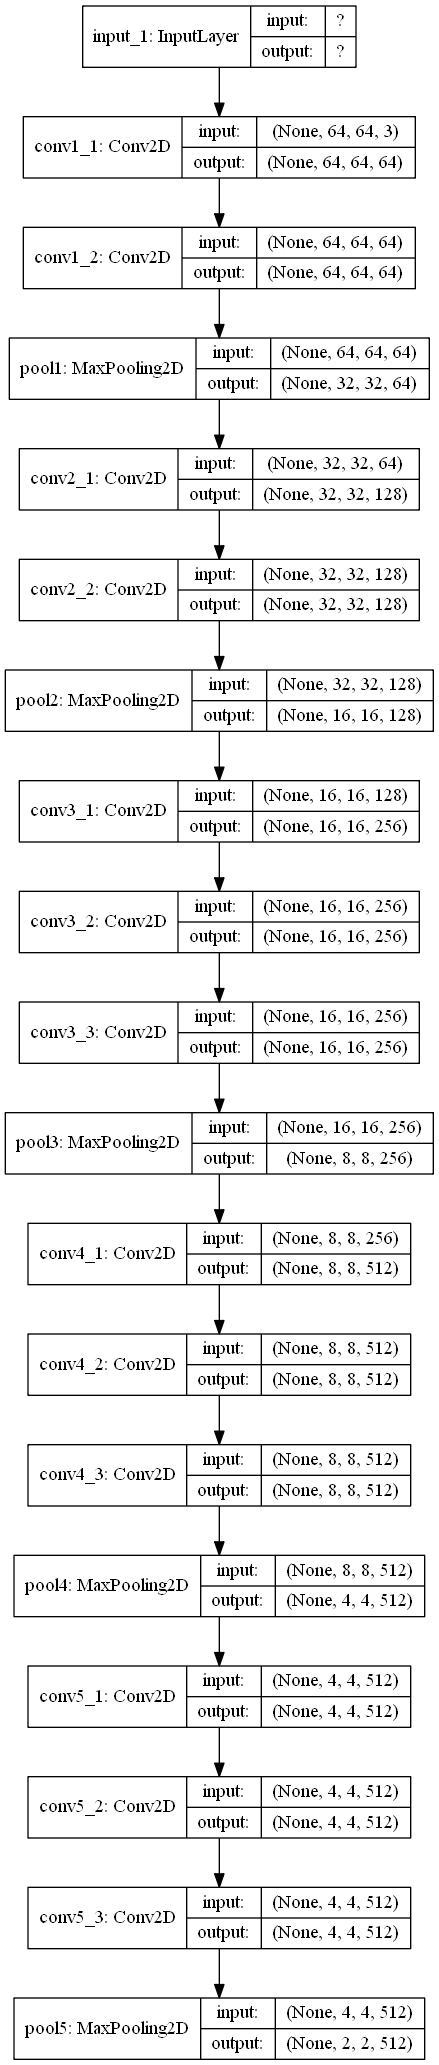

In [164]:
keras.utils.plot_model(network.layers[2], show_shapes=True)

In [263]:
# !pip install opencv-python

In [265]:
import cv2 as cv

In [336]:
cascPath = "haarcascade_frontalface_default.xml"
faceCascade = cv.CascadeClassifier(cascPath)

img = anchor[3]
gray = cv.cvtColor(img.numpy(), cv.COLOR_BGR2GRAY)
# plt.imshow(gray)
gray = np.array(gray, dtype='uint8')
faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv.CASCADE_SCALE_IMAGE
)

mask = np.zeros((gray.shape))
mask[faces[0][0]:faces[0][2],  faces[0][1]:faces[0][3]] = 1

att = gray * mask

plt.imshow(att, cmap='gray')
plt.show()

IndexError: tuple index out of range

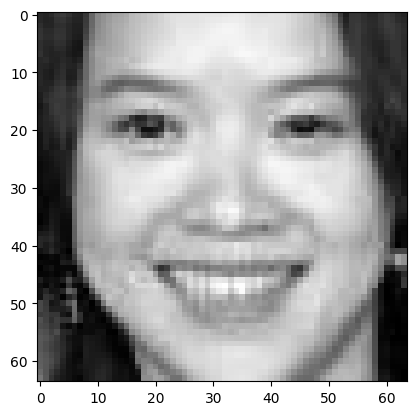

In [321]:
plt.imshow(gray, cmap='gray')
plt.show()

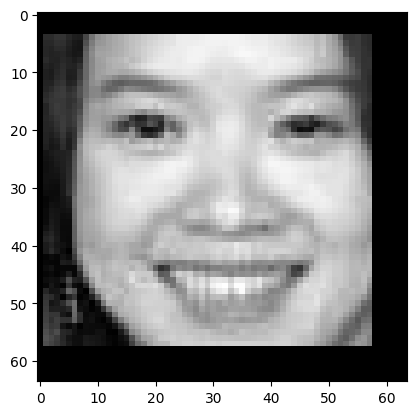

In [328]:
mask = np.zeros((gray.shape))
mask[faces[0][0]:faces[0][2],  faces[0][1]:faces[0][3]] = 1

att = gray * mask

plt.imshow(att, cmap='gray')
plt.show()

In [295]:
class PreAttention(keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        pass